In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
data = pd.read_excel('./Data1.xlsx', engine='openpyxl', skiprows=1)

In [3]:
data

,PF,PT,PH,PC,QC
0,1.264535,1.516938,0.175712,2.250178,5.300311
1,3.681563,2.031361,0.220661,4.795648,3.138023
2,1.964536,2.579357,0.305278,3.614529,2.391173
3,9.060183,2.116473,0.172418,7.628917,2.380162
4,1.163963,2.503284,0.415350,1.910409,2.370873
...,...,...,...,...,...
195,14722.940346,2.456628,0.793942,147.598057,0.006968
196,4149.276791,1.923525,0.548456,45.562246,0.006338
197,10117.279708,1.843848,0.277619,41.579690,0.006046
198,9302.101602,1.915735,0.640750,124.033254,0.005328


<AxesSubplot:xlabel='PC', ylabel='QC'>

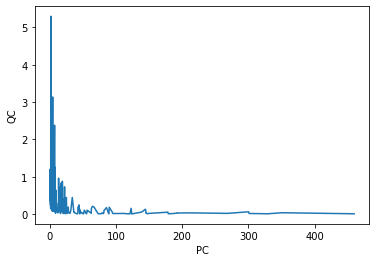

In [4]:
sns.lineplot(x = data.PC, y= data.QC)

# Обычная МНК модель 

Строим регрессию $ln(Q_c)$ на $ln(P_c)$

In [5]:
lr = LinearRegression(n_jobs=-1)

In [6]:
X = np.log(data.PC).values.reshape(-1,1)
y = np.log(data.QC)

Коэффициент при регрессоре = [-0.76616073]
R^2 = 0.5252001726952993


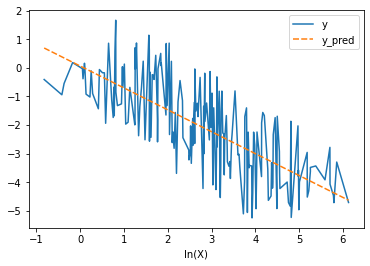

In [7]:
lr.fit(X, y)
y_pred = lr.predict(X)
print(f'Коэффициент при регрессоре = {lr.coef_}')
print(f'R^2 = {r2_score(y, y_pred)}')

plot_data = pd.DataFrame(data=[np.log(data.PC), y, y_pred]).T
plot_data.columns = ['ln(X)', 'y', 'y_pred']
plot_data.set_index('ln(X)', inplace=True)

sns.lineplot(data=plot_data);

# 2-МНК реализация

## Первый шаг мнк

Сразу приводим таргет к логарифму, так как в пайплайне его нельзя изменять 

In [8]:
class FirstStepOLS(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        x, instrument = self.unpack_x(X=X)
        x = np.array(x).reshape(-1, 1)
        first_model = LinearRegression().fit(x, instrument)
        # Выводим коэффициент при инструменте на первом шаге
        print(f'Коэффициент на первом шаге 2МНК = {first_model.coef_[0]}')
        x_hat = np.array(first_model.predict(x)).reshape(-1, 1)
        return x_hat
    
    @staticmethod
    def unpack_x(X):
        return X.T.tolist()

In [9]:
def execute_pipeline(X, y, pipeline):
    pipeline.fit(X=X, y=y)
    pipeline_pred = pipeline.predict(X=X)
    pipeline_coef = pipeline.named_steps['linear_regression'].coef_[0]
    return pipeline_pred, pipeline_coef

def ols_info(X, y):
    # Cтроим обычную регрессию
    ols_pipeline = Pipeline(steps=[
        ('to_log', FunctionTransformer(func=np.log, validate=True)),
        ('linear_regression', LinearRegression(n_jobs=-1))
    ])
    
    # Получаем МНК прогноз
    ols_pred, ols_coef = execute_pipeline(X.iloc[:,0].values.reshape(-1,1), y, ols_pipeline)
    
    # Строим 2МНК регрессию 
    two_ols_pipeline = Pipeline(steps=[
    ('data_processor', FunctionTransformer(func=np.log, validate=True)),
    ('first_step', FirstStepOLS()),
    ('linear_regression', LinearRegression(n_jobs=-1))
    ])
    # Получаем 2МНК прогноз
    two_ols_pred, two_ols_coef = execute_pipeline(X, y, two_ols_pipeline)

    # Информация по регрессии
    instrument_correlation = np.corrcoef(X.iloc[:,0], X.iloc[:,1])
    # Остатки в обычной регрессии
    residuals = y - ols_pred
    residuals_correlation = np.corrcoef(residuals, X.iloc[:,1])
    print(f'Корреляция между регрессором и инструментом = \n {instrument_correlation}')
    print(f'Корреляция между ошибками и инструментом = \n {residuals_correlation}')
    print(f'Коэффициент обычного МНК = {ols_coef}')
    print(f'Коэффициент 2МНК = {two_ols_coef}')
    print(f'R^2 = {r2_score(y, two_ols_pred)}')
    
    # Строим график
    plot_data = pd.DataFrame(data=[np.log(data.PC), y, two_ols_pred]).T
    plot_data.columns = ['ln(X)', 'y', 'y_pred']
    plot_data.set_index('ln(X)', inplace=True)
    sns.lineplot(data=plot_data);

### $P_C$ на $P_F$

Коэффициент на первом шаге 2МНК = 1.6961566728635913
Коэффициент на первом шаге 2МНК = 1.6961566728635913
Корреляция между регрессором и инструментом = 
 [[1.         0.75213697]
 [0.75213697 1.        ]]
Корреляция между ошибками и инструментом = 
 [[ 1.         -0.26555679]
 [-0.26555679  1.        ]]
Коэффициент обычного МНК = -0.7661607333464814
Коэффициент 2МНК = -0.45170398796532507
R^2 = 0.5252001726952995


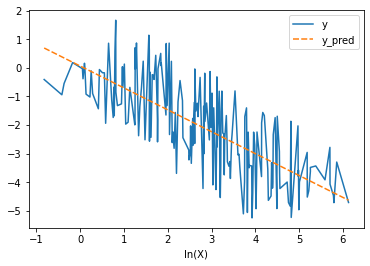

In [10]:
ols_info(data[['PC', 'PF']], y)

### $P_C$ на $P_T$

Коэффициент на первом шаге 2МНК = 0.00015722051189359955
Коэффициент на первом шаге 2МНК = 0.00015722051189359955
Корреляция между регрессором и инструментом = 
 [[1.         0.02476181]
 [0.02476181 1.        ]]
Корреляция между ошибками и инструментом = 
 [[1.         0.07407734]
 [0.07407734 1.        ]]
Коэффициент обычного МНК = -0.7661607333464814
Коэффициент 2МНК = -4873.160150152699
R^2 = 0.5252001726953128


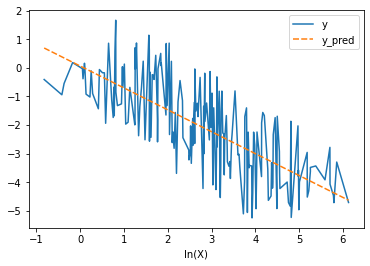

In [11]:
ols_info(data[['PC', 'PT']], y)

### $P_C$ на $P_H$

Коэффициент на первом шаге 2МНК = 0.04584585866627559
Коэффициент на первом шаге 2МНК = 0.04584585866627559
Корреляция между регрессором и инструментом = 
 [[1.         0.13931915]
 [0.13931915 1.        ]]
Корреляция между ошибками и инструментом = 
 [[ 1.         -0.10051621]
 [-0.10051621  1.        ]]
Коэффициент обычного МНК = -0.7661607333464814
Коэффициент 2МНК = -16.711667217830357
R^2 = 0.5252001726952995


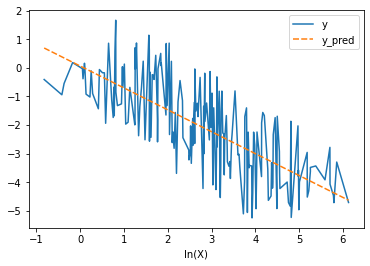

In [12]:
ols_info(data[['PC', 'PH']], y)

# Проверка 2МНК ручками

Оценим регрессию $X$ на $P_F$ 

In [13]:
test_X = np.log(data['PC']).values.reshape(-1, 1)
test_INST = np.log(data['PF'])
test_lr = LinearRegression(n_jobs=-1)
X_hat = test_lr.fit(test_X, test_INST).predict(test_X)
X_hat = np.array(X_hat).reshape(-1, 1)


In [14]:
second_step = LinearRegression()
t_ols_pred = second_step.fit(X_hat, y).predict(X=X_hat)
r2_score(y, t_ols_pred)

0.5252001726952995

In [15]:
second_step.coef_

array([-0.45170399])

In [16]:
np.corrcoef(data.PC, data.PF)

array([[1.        , 0.75213697],
       [0.75213697, 1.        ]])

## Смотрим корреляцию с остатками 

In [23]:
residuals_tols

0      2.224993
1      2.280574
2      1.792135
3      2.359829
4      1.295071
         ...   
195   -1.203963
196   -2.199277
197   -2.316519
198   -1.605567
199   -2.308451
Name: QC, Length: 200, dtype: float64

In [37]:
residuals_tols = y - t_ols_pred
np.corrcoef(X_hat.reshape(1, 200), residuals_tols.values) 

array([[1.00000000e+00, 1.51495743e-16],
       [1.51495743e-16, 1.00000000e+00]])